In [19]:
import random
random.seed(20)

In [91]:
from scipy import spatial
import time
from matplotlib import pyplot as plt

In [120]:
from sentence_transformers import SentenceTransformer

In [81]:
#This file contains code that involves generating the candidates for an input query

#Importing necessary packages
import numpy as np
import pandas as pd
import re
import torch
import faiss
import os
import pickle
import sys
from transformers import AutoTokenizer, AutoModel



#Using pre-trained models for tokenization and embeddings generation
tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/bert-base-nli-mean-tokens')
model = AutoModel.from_pretrained('sentence-transformers/bert-base-nli-mean-tokens')
model.eval()

def get_sentence_embeddings(data):
    tokens = {'input_ids': [], 'attention_mask': []}

    for sentence in data:
        # tokenize sentence and append to dictionary lists
        new_tokens = tokenizer.encode_plus(sentence, max_length=128, truncation=True,
                                          padding='max_length', return_tensors='pt')
        tokens['input_ids'].append(new_tokens['input_ids'][0])
        tokens['attention_mask'].append(new_tokens['attention_mask'][0])
#     print("tokens made!")
    
    # Flatten list of tensors into single tensor and convert to cuda tensors if necessary
    tokens['input_ids'] = torch.stack(tokens['input_ids'])
    tokens['attention_mask'] = torch.stack(tokens['attention_mask'])
    
    #Pass tokens to model to obtain output
    with torch.no_grad():
        outputs = model(**tokens)
    
    #Obtain embeddings as last hidden state
    embeddings = outputs.last_hidden_state

    #Create mask
    attention_mask = tokens['attention_mask']
    mask = attention_mask.unsqueeze(-1).expand(embeddings.size()).float()

    #Compute masked embeddings
    masked_embeddings = embeddings * mask
    summed = torch.sum(masked_embeddings, 1)
    summed_mask = torch.clamp(mask.sum(1), min=1e-9)
    
    #Perform mean pooling
    mean_pooled = (summed / summed_mask)
    
    #Convert torch tensor to numpy array
    embeddings_arr = mean_pooled.detach().numpy()

    return embeddings_arr

def obtain_trained_embeddings():
    #Reading embeddings from pkl file into a list
    objects = []
    with (open("./embeddings/embeddings_stack_overflow_answer_titles.txt", "rb")) as openfile:
        while True:
            try:
                objects.append(pickle.load(openfile))
            except EOFError:
                break
    embeddings = [item for sublist in objects for item in sublist]
    return embeddings

def faiss_index(embeddings):
    #Length of each SBERT embedding is 768
    d= 768
    
    #Creating faiss indices, adding for all embeddings
    index = faiss.IndexFlatL2(d)
    index.add(np.stack(embeddings, axis=0))
    
    return index

def run_query(query, pre_loaded_embeddings=None, return_rate=10):
    query_embedding = get_sentence_embeddings(query)
    
    #Obtain pre-processed data
    res = pd.read_pickle('../formatted_data/stackoverflow/unique_answer_titles.pkl')
    res = [x for x in res if str(x) != 'nan']
    
    #Calling functions to obtain embeddings of corpus and create faiss index
    if pre_loaded_embeddings is not None:
        embeddings = pre_loaded_embeddings
    else:
        embeddings = obtain_trained_embeddings()
    index = faiss_index(embeddings)
    
    for query, query_embedding in zip(query, query_embedding):
        distances, indices = index.search(np.asarray(query_embedding).reshape(1,768), return_rate)
        yield [res[indices[0,idx]] for idx in range(return_rate)]


In [2]:
q_links = pickle.load(open("../formatted_data/stackoverflow/q_link_pairs_titles_only.pkl", "rb"))

In [61]:
all_embeddings = obtain_trained_embeddings()
print(len(all_embeddings))

294444


In [39]:
data = [x for x in pd.read_pickle('../formatted_data/stackoverflow/unique_answer_titles.pkl') if str(x) != 'nan']

In [86]:
random.seed(20)
short_q_links = random.choices(q_links[:len(all_embeddings)], k=1000)
all_q_list = set([q for (q,a) in q_links])
short_a_list = [a for (q,a) in short_q_links]

In [87]:
def get_hit_rate(sample, embeddings, return_size):
    hits = 0
    result_sets = run_query([q for (q, _) in sample], embeddings, return_size)
    for (_, a), result_set in zip(sample, result_sets):
        if a in result_set:
            hits += 1
    return hits / len(sample)

In [88]:
hit_rates = []
times_elapsed = []
return_sizes = [5, 10, 20, 30, 50, 80, 100, 200, 500]

start_time = time.perf_counter()
for return_size in return_sizes:
    hit_rate = get_hit_rate(short_q_links, all_embeddings, return_size)
    hit_rates.append(hit_rate)
    
    end_time = time.perf_counter()
    time_elapsed = (end_time - start_time) / len(short_q_links)
    start_time = end_time
    
    times_elapsed.append(time_elapsed)
    
    print("Return size: {:03d}\tHit Rate: {:.2f}\tAvg Query Time: {:.2f}s".format(return_size, hit_rate, time_elapsed))


Return size: 005	Hit Rate: 0.10	Avg Query Time: 0.37s
Return size: 010	Hit Rate: 0.12	Avg Query Time: 0.37s
Return size: 020	Hit Rate: 0.14	Avg Query Time: 0.37s
Return size: 030	Hit Rate: 0.15	Avg Query Time: 0.37s
Return size: 050	Hit Rate: 0.17	Avg Query Time: 0.37s
Return size: 080	Hit Rate: 0.20	Avg Query Time: 0.37s
Return size: 100	Hit Rate: 0.20	Avg Query Time: 0.37s
Return size: 200	Hit Rate: 0.24	Avg Query Time: 0.37s
Return size: 500	Hit Rate: 0.29	Avg Query Time: 0.37s


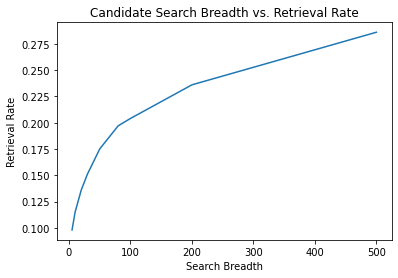

In [92]:
ax = plt.plot(return_sizes, hit_rates)
plt.title('Candidate Search Breadth vs. Retrieval Rate')
plt.xlabel('Search Breadth')
plt.ylabel('Retrieval Rate')
plt.show()

In [94]:
metric_df = pd.DataFrame({
    "Search Breadth": return_sizes, 
    "Retrieval Rate": hit_rates,
    "Avg Query Time": times_elapsed
})
metric_df["Random Baseline"] = metric_df["Search Breadth"] / len(all_embeddings)
metric_df.index = metric_df["Search Breadth"]
metric_df[["Retrieval Rate", "Random Baseline", "Avg Query Time"]]

,Retrieval Rate,Random Baseline,Avg Query Time
Search Breadth,,,
5,0.098,0.000017,0.371473
10,0.115,0.000034,0.372144
20,0.136,0.000068,0.370316
30,0.151,0.000102,0.369384
50,0.175,0.000170,0.369970
80,0.197,0.000272,0.369828
100,0.204,0.000340,0.366275
200,0.236,0.000679,0.367641
500,0.286,0.001698,0.365749


## Retrieval

In [118]:
qa_pairs = pd.read_pickle('../formatted_data/stackoverflow/answer_title_body_lookup.pkl')
qa_pairs_dict = dict(qa_pairs)

def reranking(title_list, query, return_rate):
    answers_list = []
    query_embedding = get_sentence_embeddings(query)
    
    for idx in range(return_rate):
        answers_list.append(qa_pairs_dict[title_list[idx]])
        #print(idx+1,":",qa_pairs_dict[question_list[idx]])
    answer_embeddings = get_sentence_embeddings(answers_list)
    
    return_answer_lookup = list(zip(title_list, answers_list))
    
    scored_answers = {}
    for idx,answer_embedding in enumerate(answer_embeddings):
        result = 1 - spatial.distance.cosine(query_embedding, answer_embedding)
        scored_answers[result]=return_answer_lookup[idx]
    ranked_answers = sorted(scored_answers.items(), key=lambda item: item[0], reverse = True)
    
    return ranked_answers

def run_search_and_rank(query, pre_loaded_embeddings=None, return_rate=10):
    
    query = [query] # only one at a time
    question_list = list(run_query(query, pre_loaded_embeddings, return_rate))[0]
            
    ranked_answers = reranking(question_list, query, return_rate)
    
    return [(s, t, b) for (s, (t, b)) in ranked_answers]

In [119]:
def get_answer_rank(a_title, title_list):
    if a_title not in title_list:
        return None
    return [i for (i, t) in enumerate(title_list) if t == a_title][0] + 1

In [142]:
q, a = q_links[10]
print(q, a)

scores, titles, bodies = list(zip(*run_search_and_rank(q, all_embeddings, 5)))
r = get_answer_rank(a, titles)
print(r)

How to achieve const-correctness in C#? "const correctness" in C#
4


In [147]:
random.seed(20)
short_q_links = random.choices(q_links[:len(all_embeddings)], k=10)

In [ ]:
ranks = []
rerank_times_elapsed = []

for return_size in return_sizes:
    
    curr_ranks = []
    curr_rerank_times_elapsed = []
    
    start_time = time.perf_counter()
    for _, a in short_q_links:
        _, titles, _ = list(zip(*run_search_and_rank(a, all_embeddings, return_size)))
        end_time = time.perf_counter()
        time_elapsed = end_time - start_time
        
        rank = get_answer_rank(a, titles)
        curr_ranks.append(rank)
        
        start_time = end_time
        curr_rerank_times_elapsed.append(time_elapsed)
    
    avg_rank = np.mean([rank for rank in curr_ranks if rank is not None])
    avg_time = np.mean([time_elapsed for time_elapsed in curr_rerank_times_elapsed])
    
    ranks.append(avg_rank)
    rerank_times_elapsed.append(avg_time)
    
    print("Return size: {:03d}\tAvg Rank: {:.2f}\tAvg Query Time: {:.2f}s".format(return_size, avg_rank, avg_time))


Return size: 005	Avg Rank: 2.40	Avg Query Time: 2.56s
Return size: 010	Avg Rank: 4.20	Avg Query Time: 2.97s
Return size: 020	Avg Rank: 8.20	Avg Query Time: 3.94s
Return size: 030	Avg Rank: 12.20	Avg Query Time: 4.89s
Return size: 050	Avg Rank: 19.10	Avg Query Time: 6.78s
Return size: 080	Avg Rank: 29.00	Avg Query Time: 9.82s


In [ ]:
ax = plt.plot(return_sizes, ranks)
plt.title('Candidate Search Breadth vs. Mean Rank')
plt.xlabel('Search Breadth')
plt.ylabel('Mean Rank')
plt.show()

In [ ]:
ax = plt.plot(return_sizes, rerank_times_elapsed)
plt.title('Candidate Search Breadth vs. Rank Runtime')
plt.xlabel('Search Breadth')
plt.ylabel('Avg Query Time (s)')
plt.show()

In [ ]:
rank_metric_df = pd.DataFrame({
    "Search Breadth": return_sizes, 
    "Mean Rank": ranks,
    "Avg Rank Query Time": rerank_times_elapsed
})
rank_metric_df.index = rank_metric_df["Search Breadth"]
rank_metric_df[["Mean Rank", "Avg Rank Query Time"]]

## VERIFY EMBEDDINGS AND STRINGS MATCH

In [24]:
# Check cosine matches
for i in range(0, 200):
    print(i, 1 - spatial.distance.cosine(all_embeddings[i], get_sentence_embeddings([data[i]])[0]))

0 0.9999999403953552
1 1.0
2 1.0
3 1.0
4 0.9999998807907104
5 0.9999998211860657
6 1.0
7 1.0
8 0.9999998807907104
9 1.0
10 1.0
11 0.9999998807907104
12 0.9999999403953552
13 1.0
14 0.9999998807907104
15 1.0
16 1.0
17 1.0
18 1.0
19 1.0
20 1.0
21 1.0
22 1.0
23 0.9999998807907104
24 1.0
25 0.9999999403953552
26 0.9999998807907104
27 0.9999998807907104
28 0.9999998807907104
29 0.9999998807907104
30 1.0
31 1.0
32 1.0
33 0.9999998807907104
34 0.9999999403953552
35 1.0
36 1.0
37 1.0
38 1.0
39 0.9999998807907104
40 1.0
41 1.0
42 1.0
43 0.9999998807907104
44 1.0
45 1.0
46 0.9999998807907104
47 1.0
48 1.0
49 0.9999998807907104
50 1.0
51 1.0
52 1.0
53 0.9999998807907104
54 0.9999998807907104
55 0.9999998807907104
56 0.9999998807907104
57 1.0
58 1.0
59 1.0
60 1.0
61 1.0
62 1.0
63 1.0
64 1.0
65 1.0
66 0.9999998807907104
67 1.0
68 1.0
69 0.9999998807907104
70 0.9999998807907104
71 0.9999998807907104
72 1.0
73 0.9999998807907104
74 1.0
75 0.9999998807907104
76 1.0
77 1.0
78 1.0
79 0.9999999403953552


KeyboardInterrupt: 